## Questões propostas

Esse notebook vai conter as analises realizadas a fim de responder as questões propostas no teste tecnico. Foi utilizado um banco de dados SQLite a fim de realizar as consultas SQL e os pacotes *pandas* e *matplotlib* para manipulação dos dados e criação de visualizações.

Para gerar a visualização geográfica, utilizei o pacote *gmaps* que realiza uma integração com o Google Maps.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import gmaps

sns.set_style('whitegrid')

In [2]:
conn = sqlite3.connect('../data/interim/taxi_data.db')

## Quesitos mínimos
## 1 - Qual a distância média percorrida por viagens com no máximo 2 passageiros

In [3]:
c = conn.cursor()
for row in c.execute("SELECT AVG(trip_distance) FROM trips WHERE passenger_count <= 2"):
    print('Distância média: {:0.2} KM'.format(*row))


Distância média: 2.7 KM


## 2 - Quais os 3 maiores *vendors* em quantidade total de dinheiro arrecadado

In [4]:
c = conn.cursor()
for n, row in enumerate(c.execute("SELECT vendor_id, SUM(total_amount) AS total FROM trips GROUP BY vendor_id ORDER BY total DESC LIMIT 3")):
    print('{} - Vendor: {}, Total: R$ {:0.2f}'.format(n + 1 , *row))


1 - Vendor: CMT, Total: R$ 19549084.28
2 - Vendor: VTS, Total: R$ 19043434.00
3 - Vendor: DDS, Total: R$ 2714901.72


## 3 - Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro;

In [5]:
c = conn.cursor()

data = c.execute(
    '''
    SELECT 
        strftime('%Y', pickup_datetime) AS year,
        strftime('%m', pickup_datetime) AS month,
        COUNT(*) total_count
    FROM (
        SELECT trips.pickup_datetime AS pickup_datetime, payment_lookup.payment_lookup AS payment_type 
        FROM trips INNER JOIN payment_lookup 
        ON payment_lookup.payment_type = trips.payment_type
    )
    WHERE payment_type == 'Cash'
    GROUP BY year, month
    '''
)

df = pd.DataFrame(data, columns=['year', 'month', 'count'])

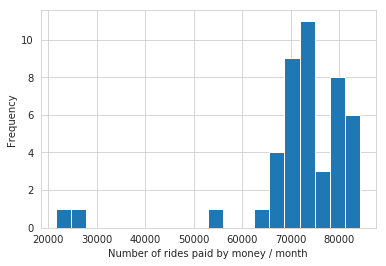

In [6]:
df['count'].plot.hist(bins=20)
plt.xlabel('Number of rides paid by money / month');

#### Obs.: Essa questão foi um pouco ambigua. Fiquei em dúvida se era para ser feito um histograma da distribuição das corridas ao longo do mês ou um histograma contendo amostras da quantidade mensal de corridas. Acabei por fazer a segunda opção por acreditar que ela faça mais sentido nesse contexo.

## 4 - Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

In [7]:
c = conn.cursor()

data = c.execute(
    '''
    SELECT 
        pickup_datetime,
        strftime('%Y', pickup_datetime) AS year,
        strftime('%m', pickup_datetime) AS month,
        strftime('%d', pickup_datetime) AS day,
        COUNT(*) as n_tips
    FROM trips
    WHERE year == '2012' AND month >= '10' AND tip_amount > 0.0
    GROUP BY year, month, day
    '''
)
df = pd.DataFrame(data, columns=['Time', 'year', 'month', 'day', 'total_tip'])
df.Time = df.Time.map(pd.Timestamp)
df = df.set_index('Time')

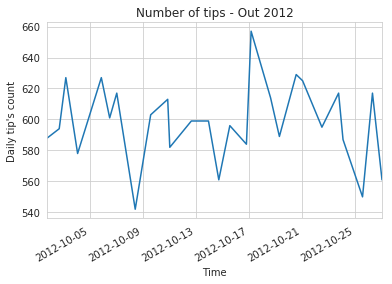

In [8]:
df.total_tip.plot()
plt.ylabel('Daily tip\'s count')
plt.title('Number of tips - Out 2012');

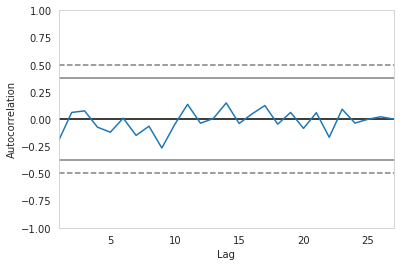

In [9]:
pd.plotting.autocorrelation_plot(df.total_tip);

#### Obs¹.: Não existem dados de corridas dos meses 11 e 12 de 2012, por isso o gráfico acima está mostrando apenas o mes 10.
#### Obs².: Fiquei em dúvida entre utilizar a contagem de gorgetas ou a soma do valor total diário em dinheiro. Acabei utilizando a contagem de gorgetas.
#### Obs³.: Não consegui enxergar um padrão na serie temporal do numero de gorgetas. Pelo gráfico de autocorrelação podemos ver que não existe nenhum padrão de sasonalidade estatiticamente relevante na serie temporal (pelo menos no intervalo analisado).

## Quesitos bônus
## Qual o tempo médio das corridas nos dias de sábado e domingo

In [10]:
c = conn.cursor()

data = c.execute(
    '''
    SELECT 
        CAST((JulianDay(dropoff_datetime) - JulianDay(pickup_datetime)) * 24 * 60 AS FLOAT) AS duration,
        CAST(strftime('%w', pickup_datetime) AS INTEGER) as wkday
    FROM trips
    WHERE wkday == 6 OR wkday == 0
    ''')

df = pd.DataFrame(data, columns=['duration', 'weekday'])

Mean duration of trips in the weekend: 8.75 minutes


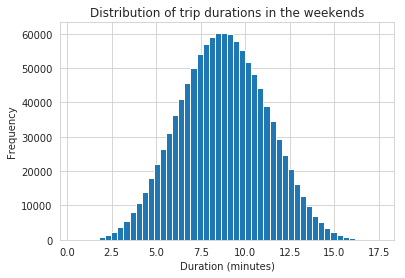

In [11]:
print('Mean duration of trips in the weekend: {:0.2f} minutes'.format(df.duration.mean()))

df.duration.plot.hist(bins=50)
plt.title('Distribution of trip durations in the weekends')
plt.xlabel('Duration (minutes)');

#### Obs.:  Como esperado, a amostragem da variável aleatória "duração da corrida" possui uma distribuição normal (devido ao grande numero de amostras. Nesse caso a distribuição foi quase uma normal "perfeita").

## Fazer uma visualização em mapa com latitude e longitude de *pickups* and *dropoffs* no ano de 2010

In [12]:
c = conn.cursor()

data = list(c.execute(
    '''
    SELECT 
        pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    FROM trips
    WHERE strftime('%Y', pickup_datetime) == '2010'
    ''')
)
df = pd.DataFrame(data, columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])


#### Obs.: A seguir será necessário o uso de yma chave de API do Goocle Cloud, como não estarei incluindo a minha no repositório não será possivel reproduzir o plot sem fornecer outra (incluí prints das visualizações geradas).

In [13]:
import os
import dotenv

dotenv.load_dotenv('../.env')

new_york_coordinates = (40.75, -74.00)
gmaps.configure(api_key=os.getenv('GMAPS_KEY'))

### Pickups

In [14]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=12)

heatmap_layer = gmaps.heatmap_layer(
    df[['pickup_latitude', 'pickup_longitude']], 
    max_intensity=1000,
)
heatmap_layer.opacity = 0.7
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

![](pickups.png)

### Dropoffs

In [15]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=12)

heatmap_layer = gmaps.heatmap_layer(
    df[['dropoff_latitude', 'dropoff_longitude']], 
    max_intensity=1000,
)
heatmap_layer.opacity = 0.7

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

![](dropoffs.png)

#### Obs.¹: Observei que a maior parte das corridas se encontra dentro de Manhattan. Fora de Manhattan, a maior concentração de corridas se encontra no aeroporto de LaGuardia (tanto para pickups quanto para dropoffs).

#### Obs.²: Vemos que os dropoffs possuem um maior difusão espacial fora de Manhattan, mostrando maior variabilidade do que os pickupps (talvez por conta de corridas para regiões mais residenciais), que parecem ser mais concentrados em regiões que provavelmente são mais movimentadas (centros comerciais / pontos turisticos).

#### Obs.³: Como esperado (confirmando consistência da base), não existem corridas se iniciando no meio dos rios de Nova Iorque ou de dentro do Central Park. 